In [1]:
#load packages
import numpy as np
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
import soundfile as sf


In [2]:
#import data 
path = 'x:/Steering/Recordings/Processed/'
data, fs = sf.read(path + 'ERB=2.wav')
classes = pd.read_csv(path + 'Classes_2.csv')


In [3]:
X = data[:len(data)-1,:data.shape[1]] #775361
Y = classes.values[:,0] - 1

In [4]:
Y

array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

In [5]:
timeSteps = 60;
features = X.shape[1];
#reshape the taining set to (samples, timeSteps, features)
tmp = X[:int(len(X)/timeSteps)*timeSteps]
X = tmp.reshape(int(len(tmp)/timeSteps),timeSteps,features)

tmp = Y[:int(len(Y)/timeSteps)*timeSteps]
Y = tmp.reshape(int(len(tmp)/timeSteps),timeSteps,1)

In [6]:
#split into training and test set
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X,Y,test_size=0.2,random_state=0)

In [7]:
trainY.shape

(14133, 60, 1)

In [8]:
trainY_OHC = keras.utils.to_categorical(trainY)
testY_OHC = keras.utils.to_categorical(testY)

In [9]:
trainY_OHC.shape

(14133, 60, 5)

In [10]:
#DC removal 
trainX -= (np.mean(trainX, axis=0) + 1e-8)
testX -= (np.mean(testX, axis=0) + 1e-8)

In [11]:
print(trainX.shape, trainY_OHC.shape) 

(14133, 60, 108) (14133, 60, 5)


In [12]:
trainY_OHC.shape, trainX.shape

((14133, 60, 5), (14133, 60, 108))

In [14]:
model = keras.Sequential()
opt = keras.optimizers.Adam(lr=0.01)

In [15]:
#design the net
model.add(keras.layers.GRU(56,input_shape = (timeSteps, features),activation='tanh',
                            return_sequences=True,dropout = 0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(5,activation='softmax',
                                                          kernel_regularizer=keras.regularizers.l2(0.001))))


In [16]:
#compiling
model.compile(loss='mean_squared_error',optimizer=opt ,metrics=['accuracy'])

In [17]:
#fit model
history = model.fit(trainX,trainY_OHC, epochs = 20, batch_size=100,validation_split=0.2)

Train on 11306 samples, validate on 2827 samples
Epoch 1/20
11306/11306 [==============================] - 10s 925us/step - loss: 0.1531 - acc: 0.3409 - val_loss: 0.1449 - val_acc: 0.4040
Epoch 2/20
11306/11306 [==============================] - 10s 885us/step - loss: 0.1361 - acc: 0.4143 - val_loss: 0.1390 - val_acc: 0.4229
Epoch 3/20
11306/11306 [==============================] - 10s 864us/step - loss: 0.1182 - acc: 0.5339 - val_loss: 0.1035 - val_acc: 0.6216
Epoch 4/20
11306/11306 [==============================] - 10s 882us/step - loss: 0.0944 - acc: 0.6660 - val_loss: 0.0846 - val_acc: 0.6951
Epoch 5/20
11306/11306 [==============================] - 10s 889us/step - loss: 0.0863 - acc: 0.6966 - val_loss: 0.0839 - val_acc: 0.7047
Epoch 6/20
11306/11306 [==============================] - 10s 915us/step - loss: 0.0827 - acc: 0.7111 - val_loss: 0.0795 - val_acc: 0.7323
Epoch 7/20
11306/11306 [==============================] - 10s 914us/step - loss: 0.0775 - acc: 0.7409 - val_loss: 0.0

In [18]:
model.evaluate(testX,testY_OHC,verbose=1)

3534/3534 [==============================] - 2s 461us/step


[0.09835226459393882, 0.695208453970166]

In [19]:
# save model and weights
#model_json = model.to_json()
#with open("GRU_56-60-5.json", "w") as json_file:
#    json_file.write(model_json)
    
#model.save_weights("GRU_56-60-5.h5")

In [20]:
#np.save('TestX_GRU_56-60-5',testX), np.save('TestY_GRU_56-60-5',testY),
#np.save('OneHot_GRU_56-60-5',testY_OHC)

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Validation', 'Training'], loc='upper left')
plt.savefig('Accuracy_GRU.png',dpi=150)

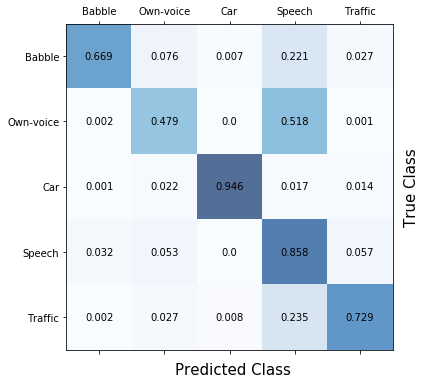

In [31]:
#confusion matrix 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

testY_1 = testY.reshape(3534*60,1)
testX_1 = model.predict_classes(testX).reshape(3534*60)

cfm = confusion_matrix(testY_1,testX_1)

a = [0 for x in range(5)]
cfm_norm = np.zeros((5,5))#[[0 for x in range(5)] for y in range(5)]

for idx in range(5):
    cfm_norm[idx,:] = cfm[idx,:] / sum(cfm[idx,:]) #len(testY[testY == idx + 1])      

cfm_norm = np.around(cfm_norm,decimals=3)

#nicer confusion matrix
fig, ax = plt.subplots(figsize = (6, 6))
ax.matshow(cfm_norm,cmap=plt.cm.Blues,alpha=0.7)

for i in range(cfm_norm.shape[0]):
    for j in range(cfm_norm.shape[1]):
        ax.text(x=j,y=i, s=cfm_norm[i,j],va='center', ha= 'center')

ax.set_xticks([0,1,2,3,4])
ax.set_yticks([0,1,2,3,4])
ax.set_xticklabels(['Babble','Own-voice','Car','Speech','Traffic'])
ax.set_yticklabels(['Babble','Own-voice','Car','Speech','Traffic'])
ax.yaxis.set_label_coords(1.08,0.5)
ax.xaxis.set_label_coords(0.51,-0.04)
ax.set_xlabel('Predicted Class',fontsize=15)
ax.set_ylabel('True Class',fontsize=15)
fig.savefig('Conf_Matrix_left_right_ERB=2.png',dpi=100)


In [32]:
FP = cfm_norm.sum(axis=0) - np.diag(cfm_norm)  
FN = cfm_norm.sum(axis=1) - np.diag(cfm_norm)
TP = np.diag(cfm_norm)
TN = cfm_norm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

ACC.mean(),TPR.mean(), FPR.mean()

(0.8944211157768447, 0.7360543456543457, 0.06598474131467133)